## Load Packages

In [1]:
using Dates, Distributions, DelimitedFiles

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [3]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# VaR for a N(μ,σ²) Return

$\textrm{VaR}_{95\%} = - 5^{th}$ percentile of the return distribution

With a $N(\mu,\sigma^2)$ distribution this gives

$\textrm{VaR}_{95\%} = - (\mu-1.64\sigma)$

In [4]:
function ϕNS(x,μ=0,σ²=1)                #pdf of N(μ,σ²), NS for "non-standard"
    pdfx = pdf(Normal(μ,sqrt(σ²)),x)    #the Distributions package wants
    return pdfx                         #Normal(μ,σ), not σ² 
end

ϕNS (generic function with 3 methods)

In [5]:
μ = 8
σ = 16

R    = range(-60,stop=60,length=301)

pdfR = ϕNS.(R,μ,σ^2)

q05   = μ - 1.64*σ 
VaR95 = -(μ - 1.64*σ)
printlnPs("with μ=$μ and σ=$σ, the 5th quantile and VaR 95% are: ",[q05 VaR95])

with μ=8 and σ=16, the 5th quantile and VaR 95% are:    -18.240    18.240


In [6]:
q05b = quantile(Normal(μ,sqrt(σ^2)),0.05)    #exact calculation of the the 5th quantile
printlnPs("get an exact result by using the quantile() function: ",q05b)

get an exact result by using the quantile() function:    -18.318


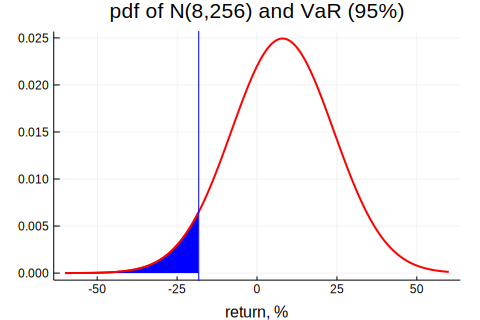

In [7]:
Rb = R[R .<= -VaR95]

p1 = plot(R,pdfR,color=:red,linewidth=2,legend=false)
plot!(Rb,ϕNS.(Rb,μ,σ^2),color=:red,linewidth=2,legend=nothing,fill=(0,:blue))
title!("pdf of N($μ,$(σ^2)) and VaR (95%)")
xlabel!("return, %")
plot!([-VaR95],linetype=:vline,color=:blue)

# Loading Daily S&P 500 Data

In [8]:
x  = readdlm("Data/SP500RfPs.csv",',',skipstart=1)
SP = convert(Array{Float64},x[:,2])       #convert to numerical array, S&P 500 level
R  = (SP[2:end]./SP[1:end-1] .- 1) * 100  #returns, % 
T  = length(R)  

dN = Date.(string.(x[2:end,1]),"d/m/y")    #convert to Date, 2:end as for R

println("Number of days in the sample: $T")

Number of days in the sample: 9352


# Backtesting VaR from N() on Data

To backtest a VaR model, study the relative frequency of Loss > VaR. 

The code below does this for difference confidence levels (0.05,0.04,...) of the VaR.

In [9]:
μ_emp = mean(R)                             #mean and std of data
σ_emp = std(R)

pval = 0.05:-0.005:0.005
L    = length(pval)
Loss = -R

VaR = fill(NaN,L)
(VaR_emp,BreakFreq) = (copy(VaR),copy(VaR))
for i = 1:L                 #loop over different (1-confidence levels)
    VaR_emp[i]   = -quantile(R,pval[i])
    VaR[i]       = -quantile(Normal(μ_emp,σ_emp),pval[i])
    BreakFreq[i] = mean(Loss .> VaR[i])           #frequency of breaking the VaR
end    

println("conf level      empirical VaR   N()-based VAR  theoretical coverage  actual coverage")
printmat([(1.0.-pval) VaR_emp VaR (1.0.-pval) (1.0.-BreakFreq)],15)

conf level      empirical VaR   N()-based VAR  theoretical coverage  actual coverage
          0.950          1.640          1.790          0.950          0.959
          0.955          1.715          1.846          0.955          0.963
          0.960          1.802          1.907          0.960          0.966
          0.965          1.886          1.975          0.965          0.968
          0.970          2.031          2.052          0.970          0.971
          0.975          2.194          2.140          0.975          0.974
          0.980          2.349          2.244          0.980          0.977
          0.985          2.566          2.373          0.985          0.981
          0.990          2.958          2.547          0.990          0.984
          0.995          3.826          2.824          0.995          0.988



The code below studes the relative frequency of Loss > VaR, but this time over a moving data window. This allows us to investigate if there are long periods of failure (in either direction) the VaR.

In [10]:
VaR95 = -(μ_emp - 1.64*σ_emp)

BreakFreqT = fill(NaN,T)                   #vector, freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreqT[t] = mean(Loss[t-100:t] .> VaR95)
end

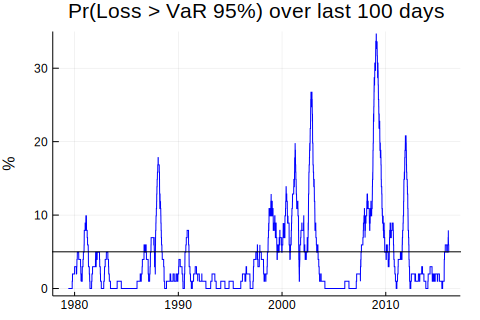

In [11]:
xTicksLoc = Dates.value.([Date(1980);Date(1990);Date(2000);Date(2010)])
xTicksLab = ["1980";"1990";"2000";"2010"]               #crude way of getting tick marks right

p1 = plot(dN,BreakFreqT*100,color=:blue,ylim=(-1,35),legend=false,xticks=(xTicksLoc,xTicksLab))
title!("Pr(Loss > VaR 95%) over last 100 days")
ylabel!("%")
plot!([5],linetype=:hline,color=:black)

# A Simple Dynamic VaR with Time-Varying Volatility

We first construct an simple estimate of $\sigma_t^2$ as a backward looking moving average

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1} -\mu_{t-1})^2$,
where $\mu_{t}=\lambda \mu_{t-1} + (1-\lambda) R_{t-1}$ 

Redo the VaR calculation using 

$\textrm{VaR}_{t} = - (\mu_t-1.64\sigma_t)$ and study if it has better properties than the static VaR

In [12]:
λ   = 0.94
s2T = fill(σ_emp^2,T)          #vector, time-varying variance
μT  = fill(μ_emp,T)
for t = 2:T
    μT[t]  = λ*μT[t-1]  + (1-λ)*R[t-1]
    s2T[t] = λ*s2T[t-1] + (1-λ)*(R[t-1]-μT[t-1])^2    #RiskMetrics approach
end

BreakFreq = fill(NaN,L)
for i = 1:L
    local critval, VaR_i
    critval      = abs(quantile(Normal(0,1),pval[i]))
    VaR_i        = -(μT .- critval*sqrt.(s2T))
    BreakFreq[i] = mean(Loss .> VaR_i)
end    

println("conf level, coverage")
printmat([(1.0.-pval) (1.0.-BreakFreq)])

conf level, coverage
     0.950     0.944
     0.955     0.947
     0.960     0.952
     0.965     0.956
     0.970     0.961
     0.975     0.966
     0.980     0.971
     0.985     0.975
     0.990     0.982
     0.995     0.987



In [13]:
VaR95 = -(μT .- 1.64*sqrt.(s2T)) 

BreakFreqT = fill(NaN,T)                   #vector, freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreqT[t] = mean(Loss[t-100:t] .> VaR95[t-100:t])
end    

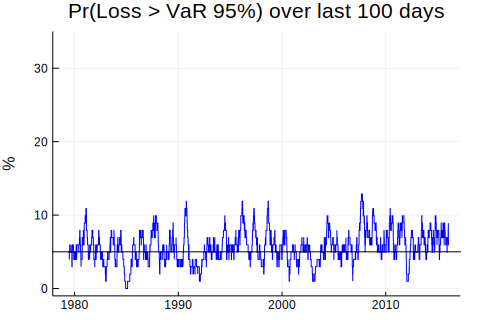

In [14]:
xTicksLoc = Dates.value.([Date(1980);Date(1990);Date(2000);Date(2010)])
xTicksLab = ["1980";"1990";"2000";"2010"]               #crude way of getting tick marks right

p1 = plot(dN,BreakFreqT*100,color=:blue,ylim=(-1,35),legend=false,xticks=(xTicksLoc,xTicksLab))
title!("Pr(Loss > VaR 95%) over last 100 days")
ylabel!("%")
plot!([5],linetype=:hline,color=:black)

# Expected Shortfall

Recall: $\text{ES}_{\alpha}=-\text{E}(R|R\leq-\text{VaR}_{\alpha})$

For a normally distributed return $R\sim N(\mu,\sigma^{2})$ we have

$\text{ES}_{95\%}=-\mu+\frac{\phi(-1.64)}{0.05}\sigma$

In [15]:
μ = 8
σ = 16
ES95 = -(μ - ϕNS(1.64)/0.05*σ)
printlnPs("N() based ES 95% with μ=$μ and σ=$σ is: ",ES95)

N() based ES 95% with μ=8 and σ=16 is:     25.268


In [16]:
ESN    = fill(NaN,L) 
ES_emp = copy(ESN)
for i = 1:L
    local critval, vv_i
    critval   = abs(quantile(Normal(0,1),pval[i]))    
    ESN[i]    = -(μ_emp .- ϕNS(critval)/pval[i]*σ_emp)
    vv_i      = Loss .> VaR_emp[i]      
    ES_emp[i] = mean(Loss[vv_i])        #mean of obs when Loss > VaR
end    

println("Conf level     ES from N()  ES (historical)")
printmat([(1 .- pval) ESN ES_emp],12)

Conf level     ES from N()  ES (historical)
       0.950       2.254       2.569
       0.955       2.303       2.668
       0.960       2.356       2.779
       0.965       2.415       2.914
       0.970       2.482       3.075
       0.975       2.560       3.270
       0.980       2.652       3.516
       0.985       2.767       3.871
       0.990       2.924       4.429
       0.995       3.176       5.628

